# Integration Benchmark - Single Cell Genomics Latin America & the Caribbean 2024

This notebook provides a comprehensive benchmark for single-cell genomics integration techniques. The aim is to evaluate various integration methods and visualize the results for better understanding.


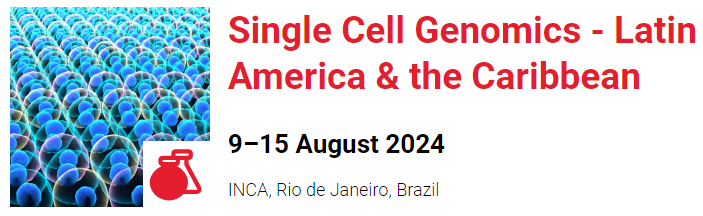

####Authors: Leandro Santos and Mariana Boroni (LBBC - INCA)

This practical class was developed to compare some of the most widely used single-cell RNA-seq integration tools. We will use the scib-metrics.benchmark tool (Luecken et al., 2022, Nature) to calculate bio-conservation and batch correction metrics and generate a benchmark using the following integration tools: Scanorama, LINGER, Harmony, scVI, and scANVI.

The dataset used in this notebook is a single-cell profiling of peripheral blood (PBMC) of patients with acute COVID-19 (2 samples: SK-013 and SK-014) and healthy volunteers (2 samples: CV-053 and CV-022) ([Ivanova et al., 2023](https://www.sciencedirect.com/science/article/pii/S2589004223026494?via%3Dihub)). You can also explore this data in [CELLxGENE](https://cellxgene.cziscience.com/e/242c6e7f-9016-4048-af70-d631f5eea188.cxg/).


## 1. Package Installation

The following packages are required for this analysis. They will be installed in the first code cell:



In [ ]:
import time

start_time = time.time()

In [ ]:
pip install numpy scanpy scib-metrics scanorama pyliger harmony-pytorch scvi-colab matplotlib scipy gdown --quiet


## 2. Library Imports

We import the necessary libraries for data manipulation, analysis, and visualization. Below is a brief description of each:

- `numpy`: For numerical computations.
- `scanpy`: For single-cell analysis.
- `pandas`: For data manipulation.
- `matplotlib`: For plotting graphs.
- `scib_metrics`: For benchmarking.
- `datashader`, `holoviews`: For advanced visualizations.
- `bokeh`: For interactive plots.


In [ ]:
import numpy as np
import scanpy as sc

from scib_metrics.benchmark import Benchmarker

%matplotlib inline

In [ ]:
import pandas as pd
import datashader as ds
import datashader.transfer_functions as tf
import datashader.bundling as bd
import matplotlib.pyplot as plt
import colorcet
import matplotlib.colors
import matplotlib.cm

import bokeh.plotting as bpl
import bokeh.transform as btr
import holoviews as hv
import holoviews.operation.datashader as hd
import gdown

In [ ]:
from scvi_colab import install

In [ ]:
install()


## 3. Data Loading and Preprocessing

In this section, we load the datasets and perform necessary preprocessing steps such as selection of high variable genes and normalization.


In [ ]:
# File ID from Google Drive
file_id = '1yom9Xft-PjkVMqlGgLAsVCnlXz0ZST35'
# Construct the download URL using the file ID
url = f'https://drive.google.com/uc?id={file_id}'
# Specify the path where the file will be saved in the Colab environment
output = '/content/adata.h5ad'

# Download the file from Google Drive
gdown.download(url, output, quiet=False)

In [ ]:
adata = sc.read("/content/adata.h5ad")

**What is h5ad?**

**File Format:** h5ad is a hierarchical data format (HDF5) used for storing single-cell data, particularly in Python's AnnData structure.

**Purpose:** Efficiently stores large-scale single-cell datasets, including gene expression matrices, metadata, and annotations.
Key Features:

**Scalability:** Handles large datasets that exceed memory limitations by storing data on disk.

**Hierarchical Structure:** Organizes data into groups and datasets, enabling easy access to specific components (e.g., expression matrices, cell annotations).

**Compression:** Supports compression, reducing file size while maintaining data integrity.

**Interoperability:** Compatible with popular single-cell analysis tools, like Scanpy, and can be converted to other formats (e.g., CSV, Loom).

**Hierarchical Structure of AnnData**


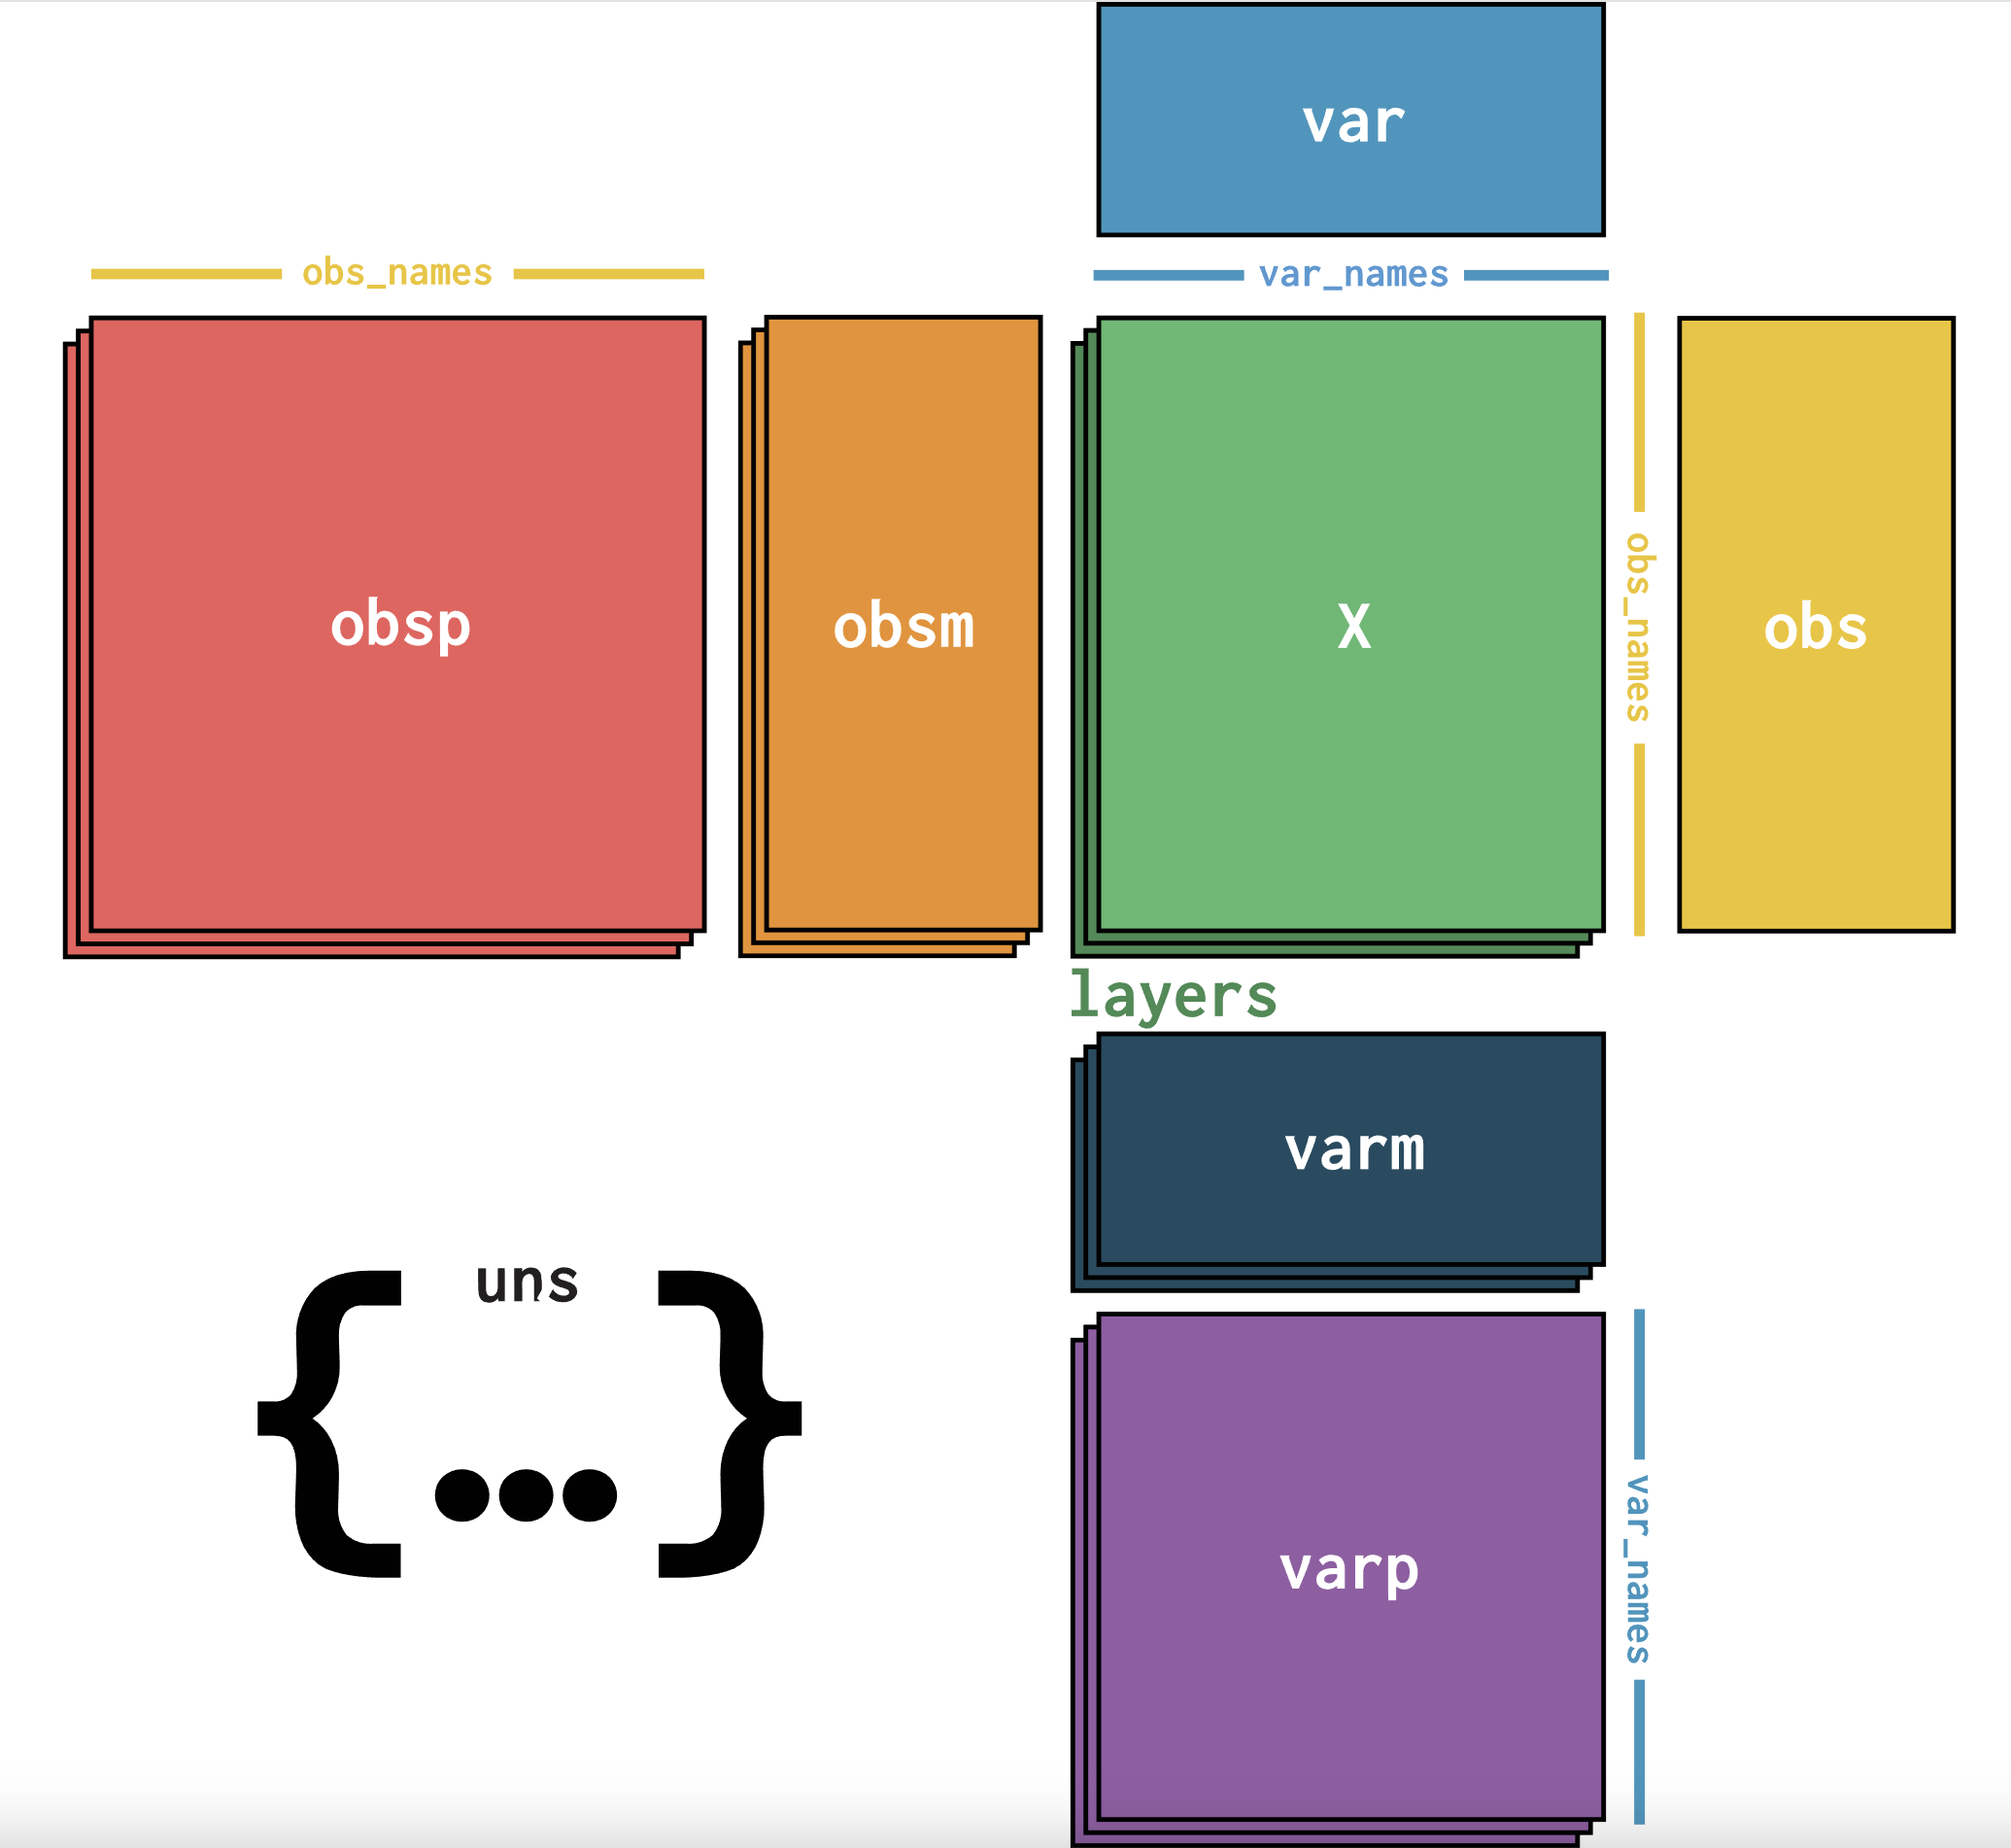
Source: https://anndata.readthedocs.io/en/latest/generated/anndata.AnnData.html



**Key Components:**

**/ (Root Group):**

The root of the h5ad file, where all data groups and datasets are organized.

**.X (Expression Matrix):**

Stores the main data matrix (e.g., gene expression counts).
Can be dense or sparse, depending on the data's storage needs.

**.obs (Observation Metadata):**

Contains metadata for cells (observations).
Includes information like cell types, sample IDs, or any other cell-specific annotations.

**.var (Variable Metadata):**

Contains metadata for genes (variables).
Includes information such as gene names, IDs, and any gene-specific annotations.

**.obsm (Observation Matrices):**

Stores matrices related to cells, like PCA or UMAP coordinates.
Each dataset within this group corresponds to a specific analysis (e.g., .obsm['X_pca'] for PCA).

**.varm (Variable Matrices):**

Similar to .obsm, but for gene-specific analyses.
Stores matrices related to genes, such as loading scores from dimensionality reduction.

**.uns (Unstructured Data):**

Stores miscellaneous data that doesn’t fit into the other structured categories.
Often used for storing parameters of analyses, color palettes for clusters, or other custom annotations.

**.layers (Additional Layers):**

Stores additional expression matrices, often representing different processing steps (e.g., raw counts, normalized counts).
Allows for easy comparison of different data representations within the same file.



## 4. Exploratory Data Analysis

Here, we perform exploratory data analysis to understand the underlying patterns and distributions in the data.


We can check all the characteristics of the data and its available information, such as nFeatures, nCounts, percentage of mitochondrial genes, number of batches, and metadata.

1 - How many cells are in this dataset?

2 - How many genes are in this dataset?

3 - How many samples are in the batch layer, and which has the most cells?

4 - What are the types of collected samples?

In [ ]:
adata

In [ ]:
adata.obs["batch"].value_counts()

This command has returned a Series showing the number of cells for each batch in the dataset.

**dtype:** int64 indicates that the data type of the values in the Series (the counts for each batch) is 64-bit integer (int64).



In [ ]:
adata.obs["tissue"].value_counts()

For the integration methods, we will use the 2000 highly variable genes (HVG) and utilize the "batch" layer in the metadata to remove batch effects. We will also perform principal component analysis (PCA) to use this layer as the unintegrated latent space. All genes will be saved for further analysis.

In [ ]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor="cell_ranger", batch_key="batch")
sc.tl.pca(adata, n_comps=30, use_highly_variable=True)

In [ ]:
print(adata.shape)
adata = adata[:, adata.var.highly_variable].copy()
print(adata.shape)

The command selects only the highly variable genes from the AnnData object and creates a new copy of the AnnData object that contains all cells but only the genes that were flagged as highly variable. This new adata object is independent of the original.


## 5. Data Visualization

In this section, we employ various plotting techniques to explore the data, uncover patterns, and identify key trends.

Preparing the Non-Integrated Dataset:

We begin by saving the PCA results as the non-integrated dataset, preserving its latent space for further analysis. Next, we calculate the nearest neighbors and apply UMAP to visualize the data, revealing underlying structures and relationships in the dataset.

In [ ]:
# Performs Principal Component Analysis (PCA) on the selected genes
sc.tl.pca(adata)

In [ ]:
# Saves the PCA results in the .obsm attribute under the key "Unintegrated"
# This essentially creates a copy of the PCA results, labeling it as "Unintegrated"
# to distinguish it from other potential embeddings or analyses.
adata.obsm["Unintegrated"] = adata.obsm["X_pca"]

In [ ]:
# Computes the nearest neighbors graph for the dataset.
# This is a crucial step for many downstream analyses, such as UMAP or clustering,
# as it defines the local neighborhood of each cell based on the previously computed PCA components.
sc.pp.neighbors(adata, use_rep = "Unintegrated")

In [ ]:
# Applies UMAP (Uniform Manifold Approximation and Projection) to the dataset.
# UMAP is a dimensionality reduction technique that projects the high-dimensional data
# into a 2D or 3D space, making it easier to visualize clusters and patterns among the cells.
sc.tl.umap(adata)

UMAP of Unintegration dataset

1 - How many cell types are there in this dataset?

2 - How is the distribution of donors in the UMAP?

In [ ]:
# Generates a UMAP plot to visualize the data with specific coloring based on cell type.
sc.pl.umap(
    adata,
    color=["cell_type"],  # Colors the cells in the UMAP plot according to the "cell_type" metadata.
                          # You can change "cell_type" to other variables like "batch" or "patientGroup"
                          # to observe the effects of integration or to highlight different metadata categories.
    # legend_loc='on data', # Optional: Uncomment to place the legend directly on the plot.
    title="Unintegrated dataset",  # Sets the title of the plot to "Unintegrated dataset".
    frameon=False,  # Removes the frame around the plot for a cleaner appearance.
    ncols=1,  # Specifies that the plot should be displayed in a single column layout.
)

In [ ]:
sc.pl.umap(
    adata,
    color=["donor_id"],
    title="Unintegrated dataset",
    frameon=False,
    ncols=1,
)

In [ ]:
sc.pl.umap(
    adata,
    color=["disease"],
    title="Unintegrated dataset",
    frameon=False,
    ncols=1,
)


## 6. Integration and Benchmarking

We integrate the datasets using different approaches and compare the results.


### Integration with Scanorama:

In [ ]:
import scipy  # Import the scipy library, which provides functions for scientific computing, including handling sparse matrices.
import scanorama  # Import the Scanorama library for batch effect correction and integration of single-cell RNA-seq data.
import numpy as np  # Import the numpy library for numerical operations, particularly for handling arrays.

# List of adata per batch
batch_cats = adata.obs.batch.cat.categories  # Get the unique categories (batch identifiers) from the 'batch' column of the 'adata' object.
adata_list = [adata[adata.obs.batch == b].copy() for b in batch_cats]  # Create a list of 'adata' objects, one for each batch, by filtering the original 'adata' based on the batch identifier.

# Convert to CSR format if needed
for i, ad in enumerate(adata_list):  # Iterate over each 'adata' object in the 'adata_list'.
    if isinstance(ad.X, scipy.sparse.csc_matrix):  # Check if the data matrix 'X' is in CSC (Compressed Sparse Column) format.
        ad.X = ad.X.tocsr()  # Convert the matrix from CSC to CSR (Compressed Sparse Row) format if necessary. CSR is often preferred for certain operations.

# Integrate with Scanorama
scanorama.integrate_scanpy(adata_list)  # Use Scanorama to integrate the list of 'adata' objects to correct for batch effects and combine the data into a unified representation.

# Prepare the integrated matrix
adata.obsm["Scanorama"] = np.zeros((adata.shape[0], adata_list[0].obsm["X_scanorama"].shape[1]))  # Initialize a new array in 'adata.obsm' to store the integrated matrix from Scanorama. The array has the same number of rows as the original 'adata' and columns equal to the Scanorama matrix dimension.
for i, b in enumerate(batch_cats):  # Iterate over each batch category.
    adata.obsm["Scanorama"][adata.obs.batch == b] = adata_list[i].obsm["X_scanorama"]  # Assign the integrated Scanorama matrix for each batch to the corresponding entries in the new matrix.

### Integration with Harmony:

In [ ]:
from harmony import harmonize  # Import the 'harmonize' function from the Harmony library, which is used for correcting batch effects in PCA-reduced data.

# Perform batch effect correction using Harmony
adata.obsm["Harmony"] = harmonize(adata.obsm["X_pca"], adata.obs, batch_key="batch")

### Integration with scVI and scANVI

Running scVI and scANVI can be time-consuming due to the complexity of the neural network.
To save time during this session, we are using a precomputed AnnData object.
This allows us to skip the training process and focus on downstream analysis.
The precomputed data contains all necessary embeddings and latent variables.

The following code is commented out to prevent execution during class.
Be sure to uncomment it when performing your analysis in a real-world scenario.

#### Integration with scVI

In [ ]:
# adata.layers['counts'] = adata.X
# Store the raw count matrix (adata.X) in the 'counts' layer of the AnnData object.
# This allows the SCVI model to use this data as the input for its analysis.

# scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")
# Prepare the AnnData object for SCVI by specifying that the raw counts are stored in the 'counts' layer.
# The 'batch' column in 'adata.obs' is used to account for batch effects during model training.

# vae = scvi.model.SCVI(adata, gene_likelihood="nb", n_layers=2, n_latent=30)
# Initialize the SCVI model with the following parameters:
# - 'gene_likelihood="nb"' specifies that the negative binomial distribution is used for modeling gene expression.
# - 'n_layers=2' sets the number of hidden layers in the neural network.
# - 'n_latent=30' sets the number of latent dimensions to learn from the data.

# vae.train()
# Train the SCVI model on the AnnData object. This step fits the model to the data and learns the latent representations.

# adata.obsm["scVI"] = vae.get_latent_representation()
# Store the learned latent representations from the SCVI model into 'adata.obsm' under the key 'scVI'.
# This representation captures the underlying structure of the data after accounting for batch effects and other variations.


#### Integration with scANVI

In [ ]:
# lvae = scvi.model.SCANVI.from_scvi_model(
#     vae,
#     adata=adata,
#     labels_key="cell_type",
#     unlabeled_category="Unknown",
# )
# Initialize the SCANVI model using the previously trained SCVI model.
# 'vae' is the trained SCVI model that serves as the starting point.
# 'adata' is the AnnData object containing the data.
# 'labels_key="cell_type"' specifies that the cell type labels are stored in the 'cell_type' column of 'adata.obs'.
# 'unlabeled_category="Unknown"' designates the category for unlabeled cells in the dataset.

# lvae.train(max_epochs=20, n_samples_per_label=100)
# Train the SCANVI model with the specified parameters:
# - 'max_epochs=20' sets the maximum number of training epochs.
# - 'n_samples_per_label=100' specifies the number of samples to use per label during training.

# adata.obsm["scANVI"] = lvae.get_latent_representation()
# Store the learned latent representations from the SCANVI model into 'adata.obsm' under the key 'scANVI'.
# This representation captures cell-type-specific latent features after incorporating the cell type labels and learning from both labeled and unlabeled cells.


We will now upload a pre-processed anndata that contains also the integration done with scVI and scANVI.

In [ ]:
# File ID from Google Drive
file_id = '1jTcrzcazDN13DluVcxH9Kv-kkIp50WIN'
# Construct the download URL using the file ID
url = f'https://drive.google.com/uc?id={file_id}'
# Specify the path where the file will be saved in the Colab environment
output = '/content/adata_scvi.h5ad'

# Download the file from Google Drive
gdown.download(url, output, quiet=False)

In [ ]:
adata_scvi = sc.read('/content/adata_scvi.h5ad')

In [ ]:
adata.obsm["scVI"] = adata_scvi.obsm["scVI"]

In [ ]:
adata.obsm["scANVI"] = adata_scvi.obsm["scANVI"]

We can always chech if we have integrated using all the necessary tools:

In [ ]:
adata

### 6. Dimensionality Reduction with Integration Neighbors

Before running the benchmark metrics and compare the integration tools performance, we can visualize the latent space and compare them between each other. First, we will calculate the distance between the neighbors using the latent space generated by each integration tool, calculate the umap and save the plot:

UMAP of Scanorama Integration

In [ ]:
sc.pp.neighbors(adata, use_rep="Scanorama")

In [ ]:
sc.tl.umap(adata)

In [ ]:
sc.pl.umap(
    adata,
    color=["cell_type"],
    title="Scanorama",
    frameon=False,
    ncols=1,
)

UMAP of Harmony Integration

In [ ]:
sc.pp.neighbors(adata, use_rep="Harmony")

In [ ]:
sc.tl.umap(adata)

In [ ]:
sc.pl.umap(
    adata,
    color=["cell_type"],
    title="Harmony",
    frameon=False,
    ncols=1,
)

UMAP of scVI Integration

In [ ]:
sc.pp.neighbors(adata, use_rep="scVI")

In [ ]:
sc.tl.umap(adata)

In [ ]:
sc.pl.umap(
    adata,
    color=["cell_type"],
    title="scVI",
    frameon=False,
    ncols=1,
)

UMAP of scANVI Integration

In [ ]:
sc.pp.neighbors(adata, use_rep="scANVI")

In [ ]:
sc.tl.umap(adata)

In [ ]:
sc.pl.umap(
    adata,
    color=["cell_type"],
    title="scANVI",
    frameon=False,
    ncols=1,
)

After running all integration tools on the same dataset with identical parameters, we will proceed to calculate and perform the benchmark analysis.

In [ ]:
# Initialize the Benchmarker object to evaluate the performance of different embeddings.
bm = Benchmarker(
    adata,  # The AnnData object containing the single-cell data and various embeddings.
    batch_key="batch",  # The key in 'adata.obs' that holds batch information for evaluating batch effects.
    label_key="cell_type",  # The key in 'adata.obs' that contains cell type labels for assessing clustering performance.
    embedding_obsm_keys=["Unintegrated", "Scanorama", "Harmony", "scVI", "scANVI"],  # The keys in 'adata.obsm' corresponding to the embeddings to be compared.
    n_jobs=2,  # The number of parallel jobs to use for computation, which can help speed up the benchmarking process.
)

# Run the benchmarking process to compare the performance of the specified embeddings.
# This involves evaluating how well each embedding method handles batch effects and clustering accuracy, based on the provided batch and label information.
bm.benchmark()

With the results of benchmarking metrics for that dataset, you can print the results in a summary board ...

In [ ]:
bm.plot_results_table()

Or in a dataframe format:

In [ ]:
from rich import print

df = bm.get_results(min_max_scale=False)
print(df)

In [ ]:
df.transpose()

In [ ]:
end_time = time.time()
elapsed_time = end_time - start_time

print(f'Total time taken: {elapsed_time:.2f} seconds')


## 7. Conclusion

In this notebook, we benchmarked various single-cell genomics integration methods and visualized the results. Future work could include more comprehensive comparisons and the inclusion of additional datasets.
